In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import gamma, gammaincc
import matplotlib.pyplot as plt

# Functions

In [2]:
def indicator(a,b,x):
    """
    indicator function in 1 dimension over the interval [xmin,xmax]
    """
    return(np.where(np.logical_or(x<a, x>=b),0,1).astype(np.float128))

def uniform_pdf(a,b,x):
    """
    discrete uniform pdf in [a,b]
    """
    a_int = int(a)
    b_int = int(b)
    return( indicator(a_int,b_int,x)/(b_int-a_int) )

def gamma_pdf(a,b,x):
    """
    Gamma distribution with shape parameter a, scale parameter b
    mean = a*b
    variance = a*b^2
    or 
    a = mean^2/sigma^2
    b = sigma^2/mean
    """
    return( (np.power(x,a-1)*np.exp(-x/b)/(gamma(a)*np.power(b,a))).astype(np.float128) )

def gamma_regularized(a,x):
    """
    Regularized incomplete upper gamma function Q(a,x)
    """
    if a>0:
        return(gammaincc( a,x ).astype(np.float128))
    else:
        return( np.zeros(x.shape[0]) )
    
'''
def normal_pdf(mean,var,x):
    """
    Normal
    """
    return(((1/np.sqrt(2*np.pi*var))
            *np.exp(-np.power(x-mean,2)/(2*var))).astype(np.float128))
'''

def normalize( f, xstep ):
    """
    normalize function f to integrate to 1 
    """
    norm = np.trapz(f, dx=xstep)
    #norm = np.sum(f)*DR
    
    if norm != 0:
        return(f/norm)
    else:
        print("invalid normalization")
        return(None)
        
def compute_posterior( prior, likelihood, xstep ):
    if prior is not None and likelihood is not None:
        posterior = normalize(prior*likelihood, xstep)    
        return( posterior )
    else:
        return(None)


def percentile(f, q, xrange, xstep):
    """
    compute the q-th percentile (q in [0,1]) of sampled function 'f'
    over range 'xrange' with step 'xstep'
    """
    if( q<=0 or q>1 ):
        print("Invalid q")
        return
    
    f_cdf = ( np.cumsum(f) * xstep )
    for k in range(1,len(xrange)):
        if( f_cdf[k-1]< q and f_cdf[k]>= q ):
            return(xrange[k])
    # return nan in case solution is not found
    return(np.nan) 

def SI_from_Gamma_distr(a,b,ndays):
    """
    Return an array of serial interval values sampled from
    Gamma(a,b) with days from 0 to ndays
    """
    return( gamma_pdf(a,b,np.arange(0,ndays+1) ) )
    
def Lambda_from_SI(incidence, wSI ):
    """
    Compute Lambda from incidence data and serial interval data.
    'incidence' and 'wSI' are both numpy arrays.
    Returns numpy array with values of Lambda.
    """
    # cast to numpy array if input is list
    if type(incidence) is list:
        print("c")
        incidence = np.array(incidence)
    if type(wSI) is list:
        print("c")
        wSI = np.array(wSI)

    # initialize Lambda array
    Lambda = np.zeros(incidence.shape[0])
    
    for t in range( incidence.shape[0] ):
        I_times_w = 0
        for j in range(max(t-wSI.shape[0]+1,0), t):    
            I_times_w += incidence[j] * wSI[t-j]
            
        Lambda[t] = round(I_times_w,3)
        
    return( Lambda )

# Input Data

In [3]:
# SERIAL INTERVAL (SI) DATA
# parameters of Serial Interval Gamma-distribution for Covid-19 from Cereda et al.
SI_shape  = 1.87     
SI_shape_sd = 0.26 # std on SI_shape
SI_scale  = 1/0.28   
SI_scale_sd = 0.04*(SI_scale**2) # std on SI_scale
SI_days = 20         

In [4]:
# INCIDENCE DATA 
# Load incidence data from file
data = pd.read_csv('Italy.csv', sep = ",")
data

,time,Incid
0,2020-01-31,3
1,2020-02-22,14
2,2020-02-23,62
3,2020-02-24,53
4,2020-02-25,97
...,...,...
73,2020-05-04,1389
74,2020-05-05,1221
75,2020-05-06,1075
76,2020-05-07,1444


# Posterior distribution via Bayesian updating

In [5]:
# SETTINGS
DR = 0.01         # Delta Rt (step for discretizing Rt)
epsilon = 1e-10   # regularizer for logarithms
tau = 7           # time window length

Incid = data.Incid 
Rrange = np.arange(DR,50+DR,DR)
prior = uniform_pdf(0,40, Rrange)

## Reported cases only and fixed Serial Interval distribution

In [6]:
Rt_base = []       # list of Rt with reported cases only and fixed SI distribution

wSI = SI_from_Gamma_distr(SI_shape, SI_scale, 20)
Lambda = Lambda_from_SI(Incid, wSI)

for t in range(tau+1, Incid.shape[0]):
    posterior = prior
    loglkl = np.zeros(Rrange.shape[0])
    
    for k in range(t-tau,t):
        loglkl += ( -Rrange*Lambda[k] 
                     + Incid[k]*np.log(Rrange/Rrange.max()) )
        loglkl = loglkl - np.max(loglkl)
        
    posterior = compute_posterior(prior,np.exp(loglkl), DR) 
    if posterior is None:
        break   

    mean = (np.sum(Rrange*(posterior))*DR )
    Rt_base.append(mean)

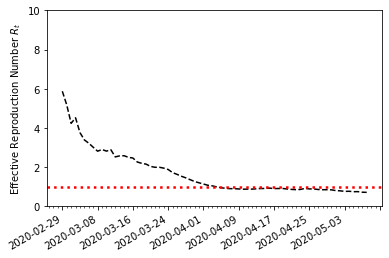

In [11]:
fig, ax = plt.subplots()

ax.plot(data.time[tau+1:],Rt_base, ls='--', c='black')
ax.axhline(1, ls=':', c='red',lw=2.5)

ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.gcf().autofmt_xdate()
ax.set_ylim([0,10])
ax.set_ylabel("Effective Reproduction Number $R_t$")

plt.show()

## Reported cases only and marginalized over Serial Interval

In [8]:
Rt_mSI = []  # list of Rt with reported cases only and marginalized over SI

for t in range(tau+1, Incid.shape[0]):
    
    marg_post = np.zeros(Rrange.shape[0])
    
    for serialint_shape in np.linspace( SI_shape - 3*SI_shape_sd,
                                        SI_shape + 3*SI_shape_sd,
                                        num=4 ):

            prob_serialint_shape = stats.norm.pdf(serialint_shape,
                                                  loc=SI_shape, scale=SI_shape_sd)

            for serialint_scale in np.linspace( SI_scale - 3*SI_scale_sd,
                                                SI_scale + 3*SI_scale_sd,
                                                num=4 ):

                prob_serialint_scale = stats.norm.pdf(serialint_scale,
                                                      loc=SI_scale, scale=SI_scale_sd)
                 
                wSI_m = SI_from_Gamma_distr(serialint_shape, serialint_scale, tau+1)                
                Lambda = Lambda_from_SI(Incid, wSI_m)
                loglkl = np.zeros(Rrange.shape[0])            
                
                for k in range(t-tau,t):    
                    q1 = gamma_regularized( Incid[k]+1, Rrange*Lambda[k])  
                    q2 = gamma_regularized( Incid[k], Rrange*Lambda[k])            
                    loglkl += np.log(q1-q2+epsilon)                              
                    loglkl = loglkl - np.max(loglkl)
                                           
                posterior = compute_posterior(prior,np.exp(loglkl), DR)                
                if posterior is None:                    
                    break  
                    
                # multiply by probabilities of nuisance parameters
                posterior *= (  prob_serialint_shape * prob_serialint_scale )
                
                # add to marginalized posterior
                marg_post += normalize(posterior,DR)
                if marg_post is None:                      
                    break  
    
    # normalize
    marg_post = normalize(marg_post,DR)
    if marg_post is None: 
        break      
    
    mean = (np.sum(Rrange*(marg_post))*DR )
    Rt_mSI.append(mean)

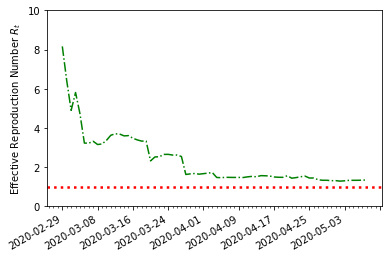

In [10]:
fig, ax = plt.subplots()

ax.plot(data.time[tau+1:],Rt_mSI, ls='-.', c='green')
ax.axhline(1, ls=':', c='red',lw=2.5)

ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.gcf().autofmt_xdate()
ax.set_ylim([0,10])
ax.set_ylabel("Effective Reproduction Number $R_t$")

plt.show()

## Ful marginalization over undetected cases and Serial Interval 
## (it takes approx 3 mins to run)

In [12]:
Rt_full = []       # list of Rt fully marginalized over undetected cases and SI 
lowerCI = []       # lower CrI with undetected
upperCI = []       # upper CrI with undetected

for t in range(tau+1, Incid.shape[0]):
    
    marg_post = np.zeros(Rrange.shape[0])
    
    for c_U in np.linspace(0,2,num=10):    

        prob_cu = 1.0 # uniform
        
        for serialint_shape in np.linspace( SI_shape - 3*SI_shape_sd,
                                            SI_shape + 3*SI_shape_sd,
                                            num=4 ):

            prob_serialint_shape = stats.norm.pdf(serialint_shape,
                                                  loc=SI_shape, scale=SI_shape_sd)

            for serialint_scale in np.linspace( SI_scale - 3*SI_scale_sd,
                                                SI_scale + 3*SI_scale_sd,
                                                num=4 ):

                prob_serialint_scale = stats.norm.pdf(serialint_scale,
                                                      loc=SI_scale, scale=SI_scale_sd)
                
                
                wSI = SI_from_Gamma_distr(serialint_shape, serialint_scale, tau+1)                
                Lambda = Lambda_from_SI(Incid, wSI)
            
                loglkl = np.zeros(Rrange.shape[0])            
                
                for k in range(t-tau,t):    
                    
                    Q1 = gamma_regularized( (1+c_U)*Incid[k]+1, Rrange*Lambda[k]) 
                    Q2 = gamma_regularized( Incid[k], Rrange*Lambda[k])           
                    loglkl += np.log(Q1-Q2+epsilon)                                
                    loglkl = loglkl - np.max(loglkl)                              
                    
                posterior = compute_posterior(prior, np.exp(loglkl), DR)                
                
                if posterior is None:
                    break  
                # multiply by probabilities of nuisance parameters
                posterior *= ( prob_cu * prob_serialint_shape * prob_serialint_scale )
                
                # add to marginalized posterior
                marg_post += normalize(posterior,DR)
                if marg_post is None:                     
                    break  
    
    # normalize
    marg_post = normalize(marg_post,DR)
    if marg_post is None: 
        break      
    
    mean = (np.sum(Rrange*(marg_post))*DR )
    Rt_full.append(mean)
    
    # 95% central credible interval
    lowerCI.append( percentile(marg_post, 0.025, Rrange, DR) )
    upperCI.append( percentile(marg_post, 0.975, Rrange, DR) )   

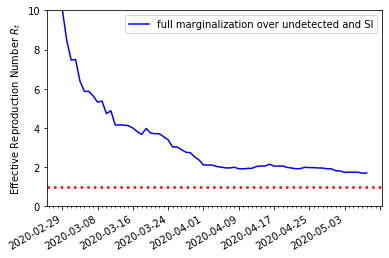

In [51]:
fig, ax = plt.subplots()

ax.plot(data.time[tau+1:],Rt_full, c='blue')
ax.axhline(1, ls=':', c='red',lw=2.5)

ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.gcf().autofmt_xdate()
ax.set_ylim([0,10])
ax.set_ylabel("Effective Reproduction Number $R_t$")

plt.show()

## Combined plot

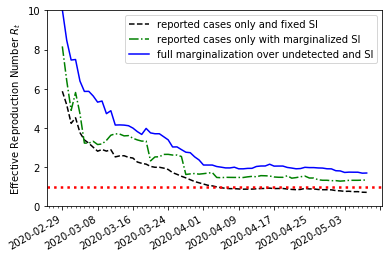

In [50]:
fig, ax=plt.subplots()

ax.plot(data.time[tau+1:],Rt_base, ls='--', c='black', label='reported cases only and fixed SI')
ax.plot(data.time[tau+1:],Rt_mSI, ls='-.', c='green', label='reported cases only with marginalized SI')
ax.plot(data.time[tau+1:],Rt_full, c='blue', label='full marginalization over undetected and SI')
ax.axhline(1, ls=':', c='red',lw=2.5)

ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.gcf().autofmt_xdate()
ax.set_ylim([0,10])
ax.set_ylabel("Effective Reproduction Number $R_t$")

plt.legend()
plt.show()